<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230316_v4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 32.3 MB/s eta 0:00:00


In [9]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_cv

from keras_cv.layers import DropBlock2D
from keras.models import Model, load_model
from keras.layers import Input, Resizing,Rescaling,BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [10]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

In [11]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')



Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [12]:
# specify image dimensions
img_height = 128
img_width = 128
num_class = 3

In [13]:
type(dataset[0])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [14]:
# Function to Normalize pixel values to 0 to 1 from 0 to 255 and subtract 1 from
# the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [15]:
# Function to resize images and segmentation masks
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [16]:
# Normalize image pixels to 0 to 1 and resize images and masks
train_images = dataset[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_images = dataset[1].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset[2].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [17]:
BUFFER_SIZE = 100
BATCH_SIZE = 32

In [18]:
# Build the input pipeline
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

validation_batches = (
    validation_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    test_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
def display(data_list):
  plt.figure(figsize=(16,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i])
    plt.axis('off')
  plt.show()


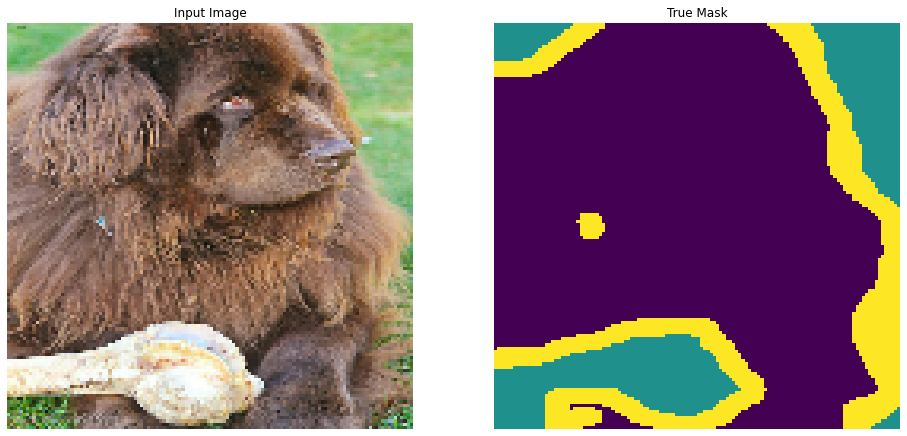

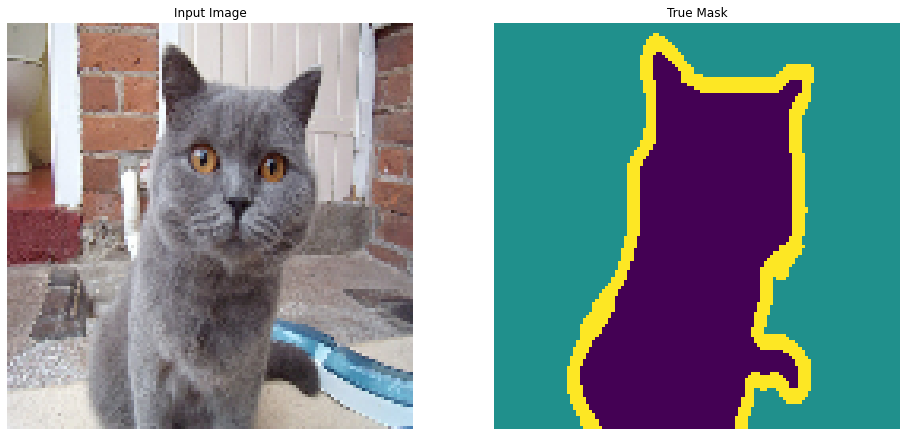

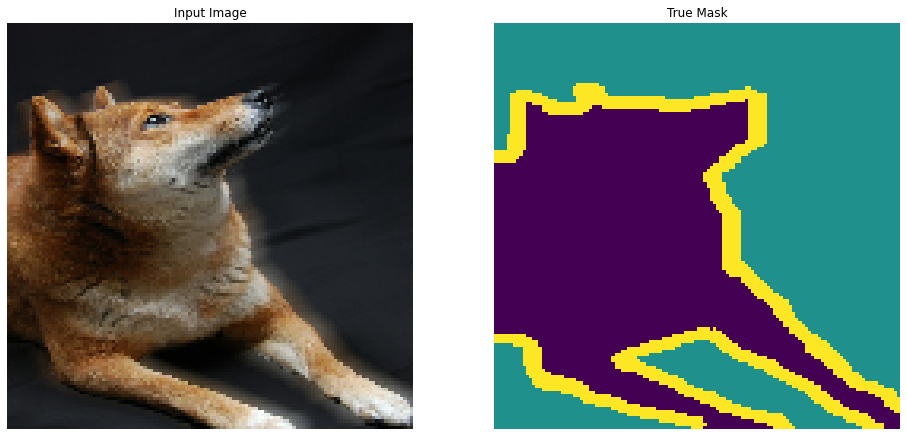

In [20]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
#IMG_HEIGHT = 128
#IMG_WIDTH = 128
#IMG_CHANNELS = 3

In [55]:

def get_model():
  inputs = Input((img_height, img_width, num_class))

  # Downsampling (encodere)
  c1 = Conv2D(filters=8, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (inputs)
  #c1 = DropBlock2D(rate=0.05,block_size=10)(c1)
  c1 = Conv2D(filters=8, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c1)
  bn1 = BatchNormalization()(c1)
  c1 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(bn1)
  # reduce imge
  p1 = MaxPooling2D(pool_size=(2, 2))(c1)

  c2 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p1)
  #c2 = DropBlock2D(rate=0.1,block_size=10)(c2)
  c2 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c2)
  bn2 = BatchNormalization()(c2)
  c2 = DropBlock2D(rate=0.1,block_size=int(img_height/4))(bn2)
  # reduce imge
  p2 = MaxPooling2D(pool_size=(2, 2))(c2)

  c3 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p2)
  #c3 = DropBlock2D(rate=0.15,block_size=10)(c3)
  c3 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c3)
  bn3 = BatchNormalization()(c3)
  c3 = DropBlock2D(rate=0.15,block_size=int(img_height/8))(bn3)
  # reduce imge from 
  p3 = MaxPooling2D(pool_size=(2, 2))(c3)

  c4 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(p3)
  #c4 = DropBlock2D(rate=0.2,block_size=10)(c4) # change from 0.2 to 0.5
  c4 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c4)
  bn4 = BatchNormalization()(c4)
  c4 = DropBlock2D(rate=0.2,block_size=int(img_height/16))(bn4)
  # reduce imge
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(p4)
  #c5 = DropBlock2D(rate=0.25,block_size=10)(c5) # change from 0.3 to 0.5
  c5 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c5)
  bn5 = BatchNormalization()(c5)
  c5 = DropBlock2D(rate=0.25,block_size=int(img_height/32))(bn5)
  # reduce imge 
  p5 = MaxPooling2D(pool_size=(2,2))(c5)

  c6 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(p5)
  #c6 = DropBlock2D(rate=0.25,block_size=10)(c6)
  c6 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c6)
  bn6 = BatchNormalization()(c6)
  c6 = DropBlock2D(rate=0.25,block_size=int(img_height/64))(bn6)
  # reduce imge 
  p6 = MaxPooling2D(pool_size=(2,2))(c6)


  c7 = Conv2D(filters=512, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(p6)
  #c7 = DropBlock2D(rate=0.25,block_size=10)(c7)
  c7 = Conv2D(filters=512, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c7)
  bn7 = BatchNormalization()(c7)
  c7 = DropBlock2D(rate=0.25,block_size=int(img_height/64))(bn7)

  # upsampling (Decoder)
  u8 = Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same')(c7)
  u8 = Concatenate()([u8, c6])
  c8 = Conv2D(filters=256, kernel_size=(3, 3),activation='elu', 
              kernel_initializer='he_normal', padding='same')(u8)
  #c8 = DropBlock2D(rate=0.25,block_size=10)(c8)
  c8 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c8)
  bn8 = BatchNormalization()(c8)
  c8 = DropBlock2D(rate=0.25,block_size=int(img_height/64))(bn8)

  u9 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same')(c8)
  u9 = Concatenate()([u9, c5])
  c9 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(u9)
  #c9 = DropBlock2D(rate=0.25,block_size=10)(c9)
  c9 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c9)
  bn9 = BatchNormalization()(c9)
  c9 = DropBlock2D(rate=0.25,block_size=int(img_height/32))(bn9)

  u10 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same')(c9)
  u10 = Concatenate()([u10, c4])
  c10 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u10)
  #c10 = DropBlock2D(rate=0.2,block_size=10)(c10) 
  c10 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c10)
  bn10 = BatchNormalization()(c10)
  c10 = DropBlock2D(rate=0.20,block_size=int(img_height/16))(bn10)

  u11 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same')(c10)
  u11 = Concatenate()([u11,c3])
  c11 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(u11)
  #c11 = DropBlock2D(rate=0.15,block_size=10)(c11) 
  c11 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same')(c11)
  bn11 = BatchNormalization()(c11)
  c11 = DropBlock2D(rate=0.15,block_size=int(img_height/8))(bn11)

  u12 = Conv2DTranspose(filters=16,kernel_size=(2,2),strides=(2,2),
                       padding='same')(c11)
  u12 = Concatenate()([u12,c2])
  c12 = Conv2D(filters=16,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(u12)
  #c12 = DropBlock2D(rate=0.1,block_size=10)(c12)
  c12 = Conv2D(filters=16,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(c12)
  bn12 = BatchNormalization()(c12)
  c12 = DropBlock2D(rate=0.10,block_size=int(img_height/4))(bn12)

  u13 = Conv2DTranspose(filters=8,kernel_size=(2,2),strides=(2,2),
                       padding='same')(c12)
  u13 = Concatenate()([u13,c1])
  c13 = Conv2D(filters=8,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(u13)
  #c13 = DropBlock2D(rate=0.05,block_size=10)(c13)
  c13 = Conv2D(filters=8,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(c13)
  bn13 = BatchNormalization()(c13)
  c13 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(bn13)
  

  # Last / top layer
  outputs = Conv2D(filters=3, kernel_size=(1, 1),activation='tanh')(c13)
  

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [56]:
unet_model = get_model()

### Performance with different optimizers<br>
#### Adam<br>
learning_rate = 0.001<br>
Training accuracy: 0.889	Training loss: 0.426	Training Mean IoU: 0.704<br>
Validation accuracy: 0.872	Validation loss: 0.458	Validation Mean IoU: 0.691<br>
<br>
Test loss: 0.45783817768096924<br>
Test accuracy: 0.8722550868988037<br>
Test MeanIoU: 0.6906632781028748<br>
<br>
Early stopping at epoch 33 (set for 75)<br>
<br>

#### AdamW (best performer)
learning_rate = 0.001<br>
batch_size = 32<br>
Training accuracy: 0.901	Training loss: 0.404	Training Mean IoU: 0.727<br>
Validation accuracy: 0.886	Validation loss: 0.434	Validation Mean IoU: 0.711<br>
<br>
Test loss: 0.4338366389274597<br>
Test accuracy: 0.8863967657089233<br>
Test MeanIoU: 0.710578203201294<br>
<br>
Early stopping at epoch 48 (set for 75)<br>
<br>
#### AdamW with reduced learning rate
learning_rate = 0.0001<br>
Training accuracy: 0.871	Training loss: 0.456	Training Mean IoU: 0.665<br>
Validation accuracy: 0.835	Validation loss: 0.529	Validation Mean IoU: 0.623<br>
<br>
Test loss: 0.5287648439407349<br>
Test accuracy: 0.8351526856422424<br>
Test MeanIoU: 0.6229840517044067<br>
<br>
Early stopping at epoch 42 (set for 75)<br>
<br>
#### AdamW with increased learning rate
learning_rate = 0.01<br>
Training accuracy: 0.454	Training loss: 1.037	Training Mean IoU: 0.205<br>
Validation accuracy: 0.425	Validation loss: 1.039	Validation Mean IoU: 0.194<br>
<br>
Test loss: 1.0394465923309326<br>
Test accuracy: 0.42521265149116516<br>
Test MeanIoU: 0.19393815100193024<br>
<br>
Early stopping at epoch 22 (set for 75)<br>
<br>

#### AdamW increase image height & width to 256
learning_rate = 0.001<br>
Training accuracy: 0.890	Training loss: 0.425	Training Mean IoU: 0.708<br>
Validation accuracy: 0.872	Validation loss: 0.462	Validation Mean IoU: 0.688<br>
<br>
Test loss: 0.4619324505329132<br>
Test accuracy: 0.871546745300293<br>
Test MeanIoU: 0.6880396008491516<br>
<br>
Early stopping at epoch 17 (set for 75)<br>
Take longer to train about 17 (~1 min per epoch)
<br>
#### Nadam
learning_rate = 0.001<br>
Training accuracy: 0.893	Training loss: 0.418	Training Mean IoU: 0.712<br>
Validation accuracy: 0.881	Validation loss: 0.440	Validation Mean IoU: 0.704<br>
<br>
Test loss: 0.4400463402271271<br>
Test accuracy: 0.8814354538917542<br>
Test MeanIoU: 0.7038891315460205<br>
Early stopping at epoch 33 (set for 75)<br>
<br>
#### Adadelta
learning_rate = 0.001<br>
Stopped training at epochs 35 with training accuracy of about 0.55 ==> prediction very poor<br>

<br>
<br>

### Performance with different activation and patterns
#### Set Action for downsampling (layers 1 - 7) to 'tanh' and for upsampling (layers 9 -13) 'elu'and last layer(output) to 'tanh'
optimizer = Adam <br>
Training accuracy: 0.867	Training loss: 0.463	Training Mean IoU: 0.666<br>
Validation accuracy: 0.838	Validation loss: 0.515	Validation Mean IoU: 0.637<br>
Test loss: 0.5152817964553833<br>
Test accuracy: 0.8380722403526306<br>
Test MeanIoU: 0.6372312903404236<br>
Early stopping at epoch 34 (set for 75)<br>
<br>

### BatchNormalization(BN) 
Added a BN after Conv2D,Dropout,Con2D layers<br>
learning_rate = 0.001<br>
Training accuracy: 0.903	Training loss: 0.401	Training Mean IoU: 0.736<br>
Validation accuracy: 0.875	Validation loss: 0.454	Validation Mean IoU: 0.699<br>
Test loss: 0.4542861580848694<br>
Test accuracy: 0.8751490116119385<br>
Test MeanIoU: 0.6985259056091309<br>


#### Set Activation for all layers to 'tanh'
optimizer = Adam <br>
Training accuracy: 0.861	Training loss: 0.474	Training Mean IoU: 0.652<br>
Validation accuracy: 0.854	Validation loss: 0.487	Validation Mean IoU: 0.652<br>
Test loss: 0.4872833490371704<br>
Test accuracy: 0.8542646765708923<br>
Test MeanIoU: 0.6519324779510498<br>
Early stopping at epoch 27 (set for 75)<br>
<br>

### Alternate Activation between 'elu' and 'tanh' with last layer Activation set to 'elu'
optimizer = Adam <br>
Training accuracy: 0.870	Training loss: 0.337	Training Mean IoU: 0.670<br>
Validation accuracy: 0.871	Validation loss: 0.355	Validation Mean IoU: 0.690<br>
Test loss: 0.3548027276992798<br>
Test accuracy: 0.8707739114761353<br>
Test MeanIoU: 0.6897278428077698<br>
Early stopping at epoch 40 (set for 75)<br>
<br>

### Use DropBlock2D instead of Dropout
#### Initial setup
Encoder setup:<br>
Conv2D<br>
DropBlock: rate = 0.05,0.1,0.15,0.2,0.25,0.25,0.25; block_size=10<br>
Conv2D<br>
BatchNormalization<br>
MaxPooling<br>
<br>
Decoder setup:<br>
Conv2D Transpose<br>
Concatenate<br>
Conv2D<br>
DropBlock: rate=0.25,0.25,0.2,0.15,0.1,0.05;block_size=10<br>
Conv2D<br>
BatchNormalization<br>
<br>
<br>
Training accuracy: 0.904	Training loss: 0.400	Training Mean IoU: 0.734<br>
Validation accuracy: 0.884	Validation loss: 0.438	Validation Mean IoU: 0.711<br>
Test loss: 0.4379971921443939<br>
Test accuracy: 0.8843867778778076<br>
Test MeanIoU: 0.7108237743377686<br>
Early stopping at epoch 31 (set for 75)<br>
<br>
#### Setup # 2
Encoder setup:<br>
Conv2D<br>
Conv2D<br>
BatchNormalization<br>
DropBlock: rate = 0.05,0.1,0.15,0.2,0.25,0.25,0.25; block_size=10<br>
MaxPooling<br>
<br>
Decoder setup:<br>
Conv2D Transpose<br>
Concatenate<br>
Conv2D<br>
Conv2D<br>
BatchNormalization<br>
DropBlock: rate=0.25,0.25,0.2,0.15,0.1,0.05;block_size=10<br>
<br>
Training accuracy: 0.905	Training loss: 0.398	Training Mean IoU: 0.732<br>
Validation accuracy: 0.883	Validation loss: 0.441	Validation Mean IoU: 0.705<br>
<br>
Test loss: 0.44094616174697876<br>
Test accuracy: 0.8826533555984497<br>
Test MeanIoU: 0.7049999237060547<br>
Early stopping at epoch 38 (set for 75)<br>
<br>
### Setup # 3: change block_size
Encoder setup same as steup # 2 but with changing block_size (to make it relative to input size):<br>
DropBlock: block_size: img_height/2, img_height/4,img_height/8,img_height/16,img_height/32 and img_height/64.<br>
<br>
Decoder setup same as steup # 2 but with changing block_size (to make it relative to input size):<br>
DropBlock: block_size: img_height/64, img_height/32,img_height/16,img_height/8,img_height/4 and img_height/2.<br>
<br>
Training accuracy: 0.886	Training loss: 0.431	Training Mean IoU: 0.701<br>
Validation accuracy: 0.877	Validation loss: 0.450	Validation Mean IoU: 0.700<br>
<br>
Test loss: 0.449978768825531<br>
Test accuracy: 0.8771989345550537<br>
Test MeanIoU: 0.700349748134613<br>
Early stopping at epoch 21 (set for 75)<br>
<br>




### Evaluate the following to see how it affect models prediction performance:<br>
1. increase image dims to 256 X 256
2. Reduce learning rate to 0.0001 and increase to 0.01
3. Try out some different optimizers
4. Change activation or alternate between two activation


In [57]:
lr = 0.001

#
unet_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.MeanIoU(num_classes=3,
                                                  sparse_y_pred = False)])

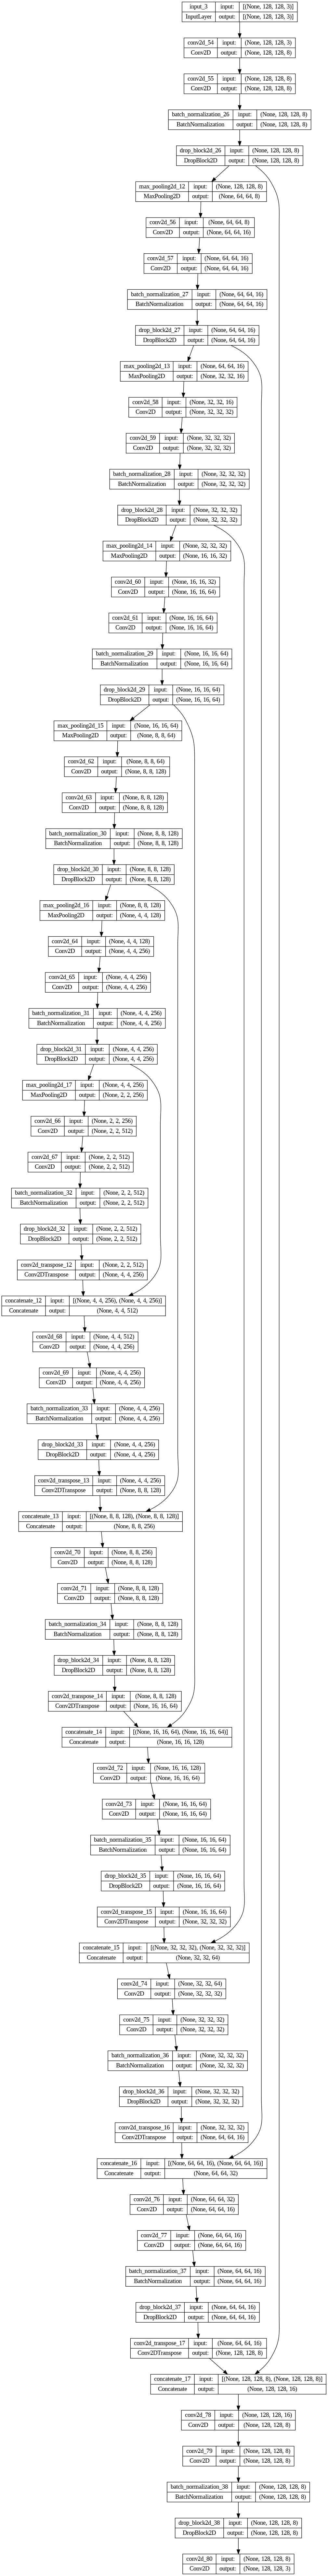

In [58]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [59]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 8)  224         ['input_3[0][0]']                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 128, 128, 8)  584         ['conv2d_54[0][0]']              
                                                                                                  
 batch_normalization_26 (BatchN  (None, 128, 128, 8)  32         ['conv2d_55[0][0]']        

In [60]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [61]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 501ms/step


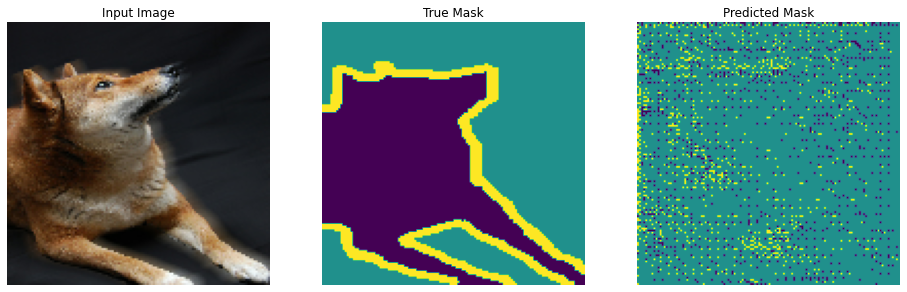

In [62]:
# show model predictions before training
show_predictions()

In [63]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [64]:
filepath = "unet_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks_list = [earlystopper,checkpoint,reduce_lr,DisplayCallback()]

1/1 [==============================] - 0s 26ms/step


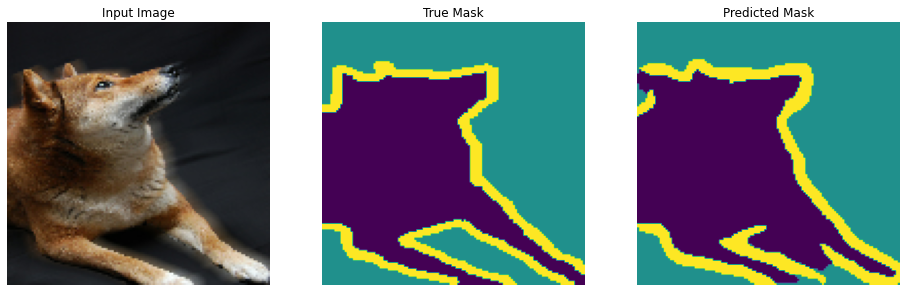


Sample Prediction after epoch 21

196/196 [==============================] - 33s 168ms/step - loss: 0.4310 - accuracy: 0.8862 - mean_io_u_2: 0.7011 - val_loss: 0.4500 - val_accuracy: 0.8772 - val_mean_io_u_2: 0.7003 - lr: 0.0010
Epoch 21: early stopping


In [65]:
EPOCHS = 75


model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          validation_data=test_batches,
                          callbacks=callbacks_list)

In [66]:
var = list(model_history.history.keys())
var

['loss',
 'accuracy',
 'mean_io_u_2',
 'val_loss',
 'val_accuracy',
 'val_mean_io_u_2',
 'lr']

In [67]:
def show_history(model_history):
  
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[2]]
  val_mean_iou = model_history.history[var[5]]
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))

  plt.subplot(1,3,1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')


  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, mean_iou, label='Training Mean_IoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation Mean_IoU')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Mean IoU')
  plt.show()

  train_acc = model_history.history['accuracy'][-1]
  val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[2]][-1]
  val_meanIoU = model_history.history[var[5]][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}\tTraining Mean IoU: {train_meanIoU:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tValidation loss: {val_loss:.3f}\tValidation Mean IoU: {val_meanIoU:.3f}')
  


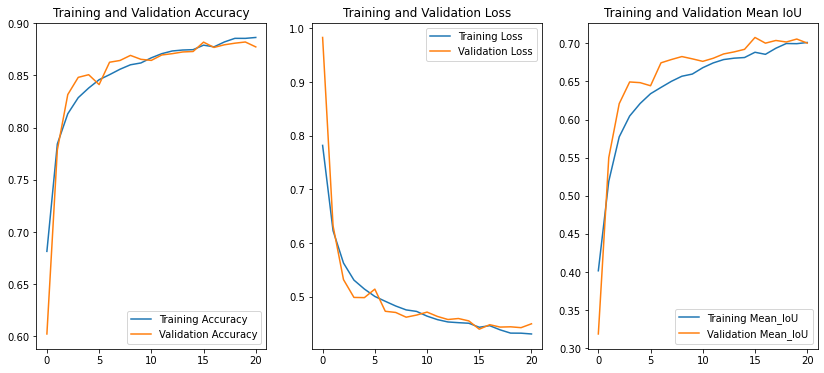

Training accuracy: 0.886	Training loss: 0.431	Training Mean IoU: 0.701
Validation accuracy: 0.877	Validation loss: 0.450	Validation Mean IoU: 0.700


In [68]:
show_history(model_history)

In [69]:
test_loss,test_accuracy,test_meaniou =  unet_model.evaluate(test_batches)

12/12 [==============================] - 0s 30ms/step - loss: 0.4500 - accuracy: 0.8772 - mean_io_u_2: 0.7003


In [70]:
print(f'Test loss: {test_loss}\nTest accuracy: {test_accuracy}\nTest MeanIoU: {test_meaniou}')

Test loss: 0.449978768825531
Test accuracy: 0.8771989345550537
Test MeanIoU: 0.700349748134613
